In [1]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate

import matplotlib.pyplot as plt
import scipy.integrate as inv
import numpy as np
import scipy.special as special

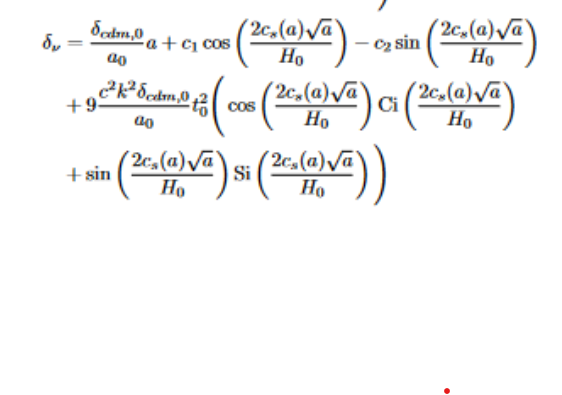

H0=0.00022333333333333333
2/(3*t0)=7.165356568444998e-05


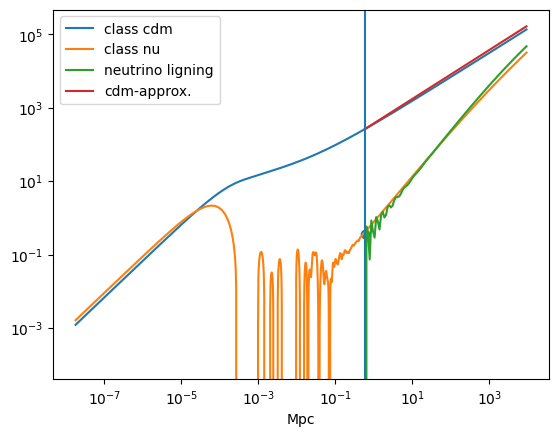

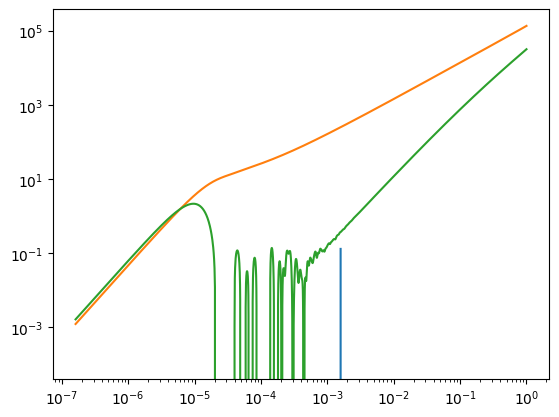

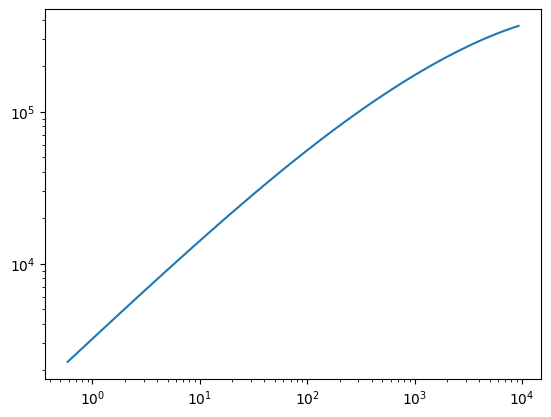

In [8]:
def TEST(kvec=[1],k_ind=0,z=600,mv_test=1 ,   Omega_M = 1, sim_include=False):
    # C kode funktions kopier for at jeg nemt og hurtigt kan importere CForm af mathmatica løsningerne.
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    cs_factor = (15*special.zeta(5)/special.zeta(3) *(4/11)**(2/3))**0.5
    ,#cs_factor /= 4 # hvorfor!
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), 
                 "N_ncdm":1,"m_ncdm":mv_test 
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3}

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    print(f"{H0=}")
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    # det kommer af Gyrs * c = 306.4 Mpc
    tid = bg['proper time [Gyr]'] * c / 306.4
    pts = cosmo.get_perturbations()['scalar']
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T0 = Tv_k * kb
        mv = mv_test * 1e-6
        return factor *T0 / a / mv


    # henter class data
    #=======================
    delta_class = pts[k_ind]["delta_cdm"]
    theta_class = pts[k_ind]["theta_cdm"]
    tau_class = pts[k_ind]["tau [Mpc]"]
    delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
    theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
    a_class = pts[k_ind]["a"]
    #=======================

    # interpolation af class data
    # ==============================
    tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
    interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)
    interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class)
    delta_init = scipy.interpolate.interp1d(tau_class,delta_class)
    delta_tid = scipy.interpolate.interp1d(tid_class,delta_class)

    neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)
    theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
    neu_interp = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
    a_interp = scipy.interpolate.interp1d(tau_class,a_class)
    a_interp_tid = scipy.interpolate.interp1d(a_class,tid_class)
    # ===============================

        # valg af z-start værdi
    # ===============================
    a0 = 1/(1+z)
    a_span = [a0,1]
    # ===============================
    # danner start værdier for conformal og fysisk tid og delta_cdm
    # ===============================
    T_ini = float(interp_tau_from_a(a0))
    T_ini_tid = float(interp_tid_from_a(a0))
    T_0 =  float(T_ini_tid)
    delta0 = delta_init(T_ini)
    # ===============================


    # Jeg har skreve cs(a) som c/a i mathmatica så vi definere først c som konstant
    # ===============================
    c = cs(1)
    # ===============================

    # diff ligning i fysisk tid
    # ===============================
    t0 = tid[-1]
    t = [T_0,tid[-1]]
    a0 = ((T_0)/tid[-1])**(2/3)
    # ===============================
    print(f"{2/(3*t0)=}")
    plt.figure(2)
    plt.loglog(tid_class,-delta_class,label="class cdm")
    plt.plot(tid_class,-delta_neutrino_class,label="class nu")
    if sim_include == True:
        def func(t,y,a0): 
            delta = y[0]
            d_delta = y[1]    
            H = 2/3 * t**(-1)
            a = (t/t0)**(2/3)
            d2_delta = - 2 * H * d_delta + 3/2 * (H**2) * delta0/(a0) * a - (cs(a)*k)**2 * delta/a**2
            return [d_delta,d2_delta]
        y0 = np.array([neu_interp(a0),0])
        sol = scipy.integrate.solve_ivp(func,t,y0,args=(a0,))
        plt.plot(sol.t,-sol.y[0],label="sim nu")
    
    plt.xlabel("Mpc")
    plt.scatter(T_ini_tid,-neu_interp(a0))

    A = np.sqrt(neu_tid(T_0)**2 + (theta_neu_tid(T_0)/ (c*k*(t0/T_0)**(4/3)))**2)
    c1 = A
    C1 = c1
    c2 = 9/2 * np.pi *c**2 *k**2 * t0**2 * (delta0/a0)
    C2 = c2
    c2k2 = c**2 * k **2
    
    dcdm = delta0/a0
    t = np.logspace(np.log10(T_0),np.log10(tid[-1]),100)

    def f1(t):
        return A * np.cos(3* c*k * t0**(4/3) /(t**(1/3)) )

    def f2(t):
        return (dcdm*Power(t,2/3))/Power(t0,2/3) +C1*Cos((3*Sqrt(c2k2)*Power(t0,4/3))/Power(t,1/3))+9*c2k2*dcdm*Power(t0,2)*Cos((3*Sqrt(c2k2)*Power(t0,4/3))/Power(t,1/3))*CosIntegral((3*Sqrt(c2k2)*Power(t0,4/3))/Power(t,1/3)) - C2*Sin((3*Sqrt(c2k2)*Power(t0,4/3))/      Power(t,1/3)) +    9*c2k2*dcdm*Power(t0,2)*Sin((3*Sqrt(c2k2)*Power(t0,4/3))/Power(t,1/3))*SinIntegral((3*Sqrt(c2k2)*Power(t0,4/3))/Power(t,1/3)) 
    
        
    def f3(a):
        H0 = 2/(3*t0)
        val = 2 * cs(a) * np.sqrt(a)  / H0
        si,ci = special.sici(val)
        return dcdm * a + C1 * np.cos(val) - C2 * np.sin(val) + 9 * (cs(a)*a)**2  * k**2 * dcdm * t0**2 * (np.cos(val) * ci +np.sin(val) * si)
        
    def f4(t):
        a = (t/t0)**(2/3)
        val = 2 * cs(a) * np.sqrt(a)  / H0
        si,ci = special.sici(val)
        return dcdm * a + C1 * np.cos(val)  - C2 * np.sin(val) + 9 * (cs(a)*a)**2  * k**2 * dcdm * t0**2 * (np.cos(val) * ci +np.sin(val) * si)
        
    plt.loglog(t,-f2(t),label="neutrino ligning")
    plt.loglog(t,-dcdm*Power(t/t0,2/3) ,label="cdm-approx.")
    
    plt.legend()
    plt.axvline(T_0)
    plt.figure(3)
    """a0 = 1/(1+z)
    a_span = [a0,1]"""
    a = np.logspace(np.log10(a0),0,100)
    plt.loglog(a,f3(a))
    
    plt.loglog(a_class,-delta_class,label="class cdm")
    plt.plot(a_class,-delta_neutrino_class,label="class nu")
    plt.figure(45)
    plt.loglog(t,f4(t),label="neutrino ligning2")
    return None
TEST()
#TEST(kvec=[1],k_ind=0,z=600,mv_test=1,Omega_M = 0.3)
plt.savefig("test")


Vi starter i $t_s$ og slutter i $t_0$ (idag)

$\ddot{\delta} +2 H \dot{\delta} + \frac{c_s ^2 k^2}{a^4}\delta = \frac{3}{2} H^2 \delta_{cdm}$

$\delta_{cdm} = \frac{\delta_{cdm,ts}}{a_s} a$

Hvor $a_s =  \left(\frac{t_s}{t_0}\right) ^{2/3}$

$a = \left(\frac{t}{t_0}\right) ^{2/3}$

$ H = \frac{2}{3} \frac{1}{t}$

i Mathmatica:

$ K1 = \delta_{cdm,ts} / a_s$

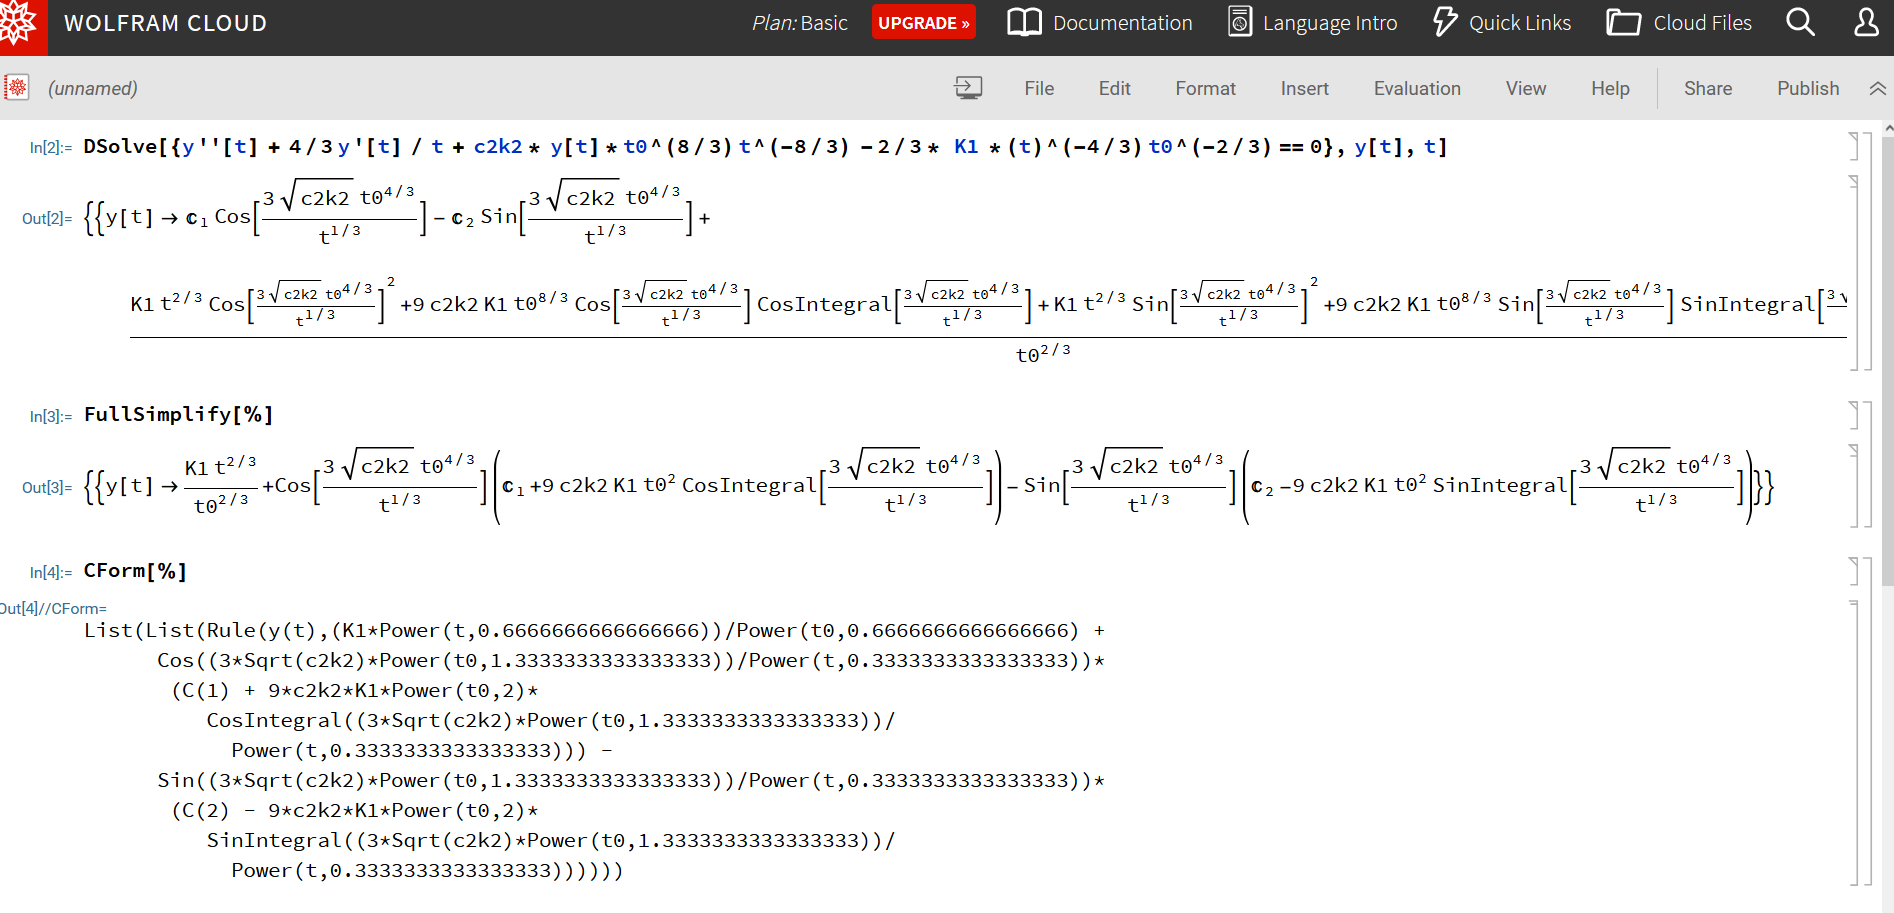

$A = 3 c_s(a=1) k t_0\; B = 3 c_s(a_{ts}) k t_s / a_{ts}$



$S_I A = sinIntegral(A)$

$C_I A = cosIntegral(A)$

$S_I B = sinIntegral(B)$

$C_I B = cosIntegral(B)$

$S_A = sin(A)\; C_A = cos(A) \; S_B = sin(B) \; C_B = cos(B)$

$c_1 = \frac{\delta_{ts}-\delta_{\nu,ts} + \delta(t_s)B^2 C_IB + s_B \delta_{ts} B^2 S_IB - \frac{s_B}{s_A}(\delta(t_0)-\delta_{\nu,t_0} + c_A \delta_{t_0} A^2 C_IA + s_A \delta_{t_0}A^2 S_I A)  }{S_BC_A/S_A - C_B}\;$
$c_2 = \frac{1}{s_A}(\delta_{t_0}-\delta_{\nu,t_0}+c_A \delta_{t_0} A^2 C_IA s_A \delta_{t_0} A^2 S_I A) + \frac{c_A}{s_A}c_1$


$\delta_{\nu} = \delta_{cdm} + \cos(3c_s(a) kt/a) \left(c_1 + \delta_{cdm} (3c_s(a)kt/a)^2cosInt(3c_s(a)kt/a)\right) - \sin(3c_s(a)kt/a)\left(c_2 - \delta_{cdm}(3c_s(a)kt/a)^2SinInt(3c_s(a)kt/a)\right)$


In [3]:

t = np.logspace